# Attention in detail

This notebook tries to visualize and explain the attention concept used in deep learning and is based on:<br>
1. [Dissecting BERT](https://medium.com/dissecting-bert/dissecting-bert-part-1-d3c3d495cdb3) (initially triggered looking into attention)
* [Harvard NLP annotated transformer](http://nlp.seas.harvard.edu/2018/04/03/attention.html#attention)
* [Udacity DL attention notebook](https://github.com/udacity/deep-learning-v2-pytorch/blob/master/attention/)
* [PyTorch einsum for attention](https://rockt.github.io/2018/04/30/einsum) (looking into attention is the perfect oppertunity to get comfortable with einsum)

In [1]:
# basic
import math

# PyTorch
import torch
import torch.nn.functional as F
from torch import einsum

# visualisation
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# random tensors function from https://rockt.github.io/2018/04/30/einsum
def random_tensors(shape, num=1, requires_grad=False):
    tensors = [torch.randn(shape, requires_grad=requires_grad) for i in range(0,num)]
    return tensors[0] if num == 1 else tensors

# Scale dot-product attention function

$\text{softmax}\left (\frac{QK^{T}}{\sqrt{d_k}}\right )V$

## Plain PyTorch 

In [3]:
# dimensions = batch size x sequence length x embedding dimension
Y = random_tensors([3, 5, 7])

In [128]:
# attention function based on http://nlp.seas.harvard.edu/2018/04/03/attention.html#attention
def attention_transf(query, key, value):
    "Compute 'Scaled Dot Product Attention'"
    
    # scaling factor for scores
    d_k = query.size(-1)
    
    # matrix multiplication to get every dot product for query and transposed key
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
    
    # apply softmax of the scores on the last dimensions (= sequence length)
    p_attn = F.softmax(scores, dim=-1)
    
    # matrix multiplication of attention matrix and value matrix to get output based
    out = torch.matmul(p_attn, value)
    
    return out, p_attn

In [129]:
# run Y through attention function
out, p_attn = attention_transf(Y, Y, Y)

In [130]:
# print shapes
Y.shape, p_attn.shape, out.shape

(torch.Size([3, 5, 7]), torch.Size([3, 5, 5]), torch.Size([3, 5, 7]))

## Einsum

In [131]:
# attention function based on http://nlp.seas.harvard.edu/2018/04/03/attention.html#attention
def attention_transf_einsum(query, key, value):
    "Compute 'Scaled Dot Product Attention'"
    
    # scaling factor for scores
    d_k = query.size(-1)
    
    # matrix multiplication to get every dot product for query and transposed key
    #scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
    scores = einsum("bij,bmj->bim", query, key) / math.sqrt(d_k)
    
    # apply softmax of the scores on the last dimensions (= sequence length)
    p_attn = F.softmax(scores, dim=-1)
    
    # matrix multiplication of attention matrix and value matrix to get output based
    #out = torch.matmul(p_attn, value)
    out = einsum("bij,bjk->bik", p_attn, value)
    
    return out, p_attn

In [132]:
# run Y through attention function
out_einsum, p_attn_einsum = attention_transf_einsum(Y, Y, Y)

In [133]:
# print shapes
Y.shape, p_attn.shape, out.shape

(torch.Size([3, 5, 7]), torch.Size([3, 5, 5]), torch.Size([3, 5, 7]))

In [134]:
# print shapes
Y.shape, p_attn_einsum.shape, out_einsum.shape

(torch.Size([3, 5, 7]), torch.Size([3, 5, 5]), torch.Size([3, 5, 7]))

In [135]:
torch.allclose(p_attn, p_attn_einsum), torch.allclose(out, out_einsum)

(True, True)

In [136]:
torch.all(torch.eq(p_attn, p_attn_einsum)), torch.all(torch.eq(out, out_einsum))

(tensor(True), tensor(True))

## Attention shapes step by step

In [13]:
# input dimmension = batch size x sequence length x embedding dimension
Y.shape

torch.Size([3, 5, 7])

In [14]:
# transpose the last two dimension to enable matrix multiplication in the next step
Y.transpose(-2, -1).shape

torch.Size([3, 7, 5])

In [15]:
# matrix multiplication for attention matrix
torch.matmul(Y, Y.transpose(-2, -1)).shape

torch.Size([3, 5, 5])

In [16]:
# matrix multiplication for output
torch.matmul(torch.matmul(Y, Y.transpose(-2, -1)), Y).shape

torch.Size([3, 5, 7])

### Softmax dimension in attention matrix

In [17]:
# check attention matrix shape
p_attn.shape

torch.Size([3, 5, 5])

In [18]:
# print attention matrix
p_attn

tensor([[[8.0548e-01, 8.1621e-03, 1.4018e-01, 2.4387e-02, 2.1787e-02],
         [2.8013e-03, 9.1121e-01, 3.2232e-02, 4.6189e-02, 7.5630e-03],
         [2.6030e-01, 1.7438e-01, 4.6316e-01, 7.5547e-02, 2.6608e-02],
         [3.9921e-03, 2.2031e-02, 6.6603e-03, 9.5825e-01, 9.0625e-03],
         [2.9709e-02, 3.0049e-02, 1.9540e-02, 7.5491e-02, 8.4521e-01]],

        [[8.3923e-01, 1.1118e-02, 1.0271e-02, 4.1018e-02, 9.8359e-02],
         [7.2355e-03, 7.5496e-01, 1.5436e-02, 8.0949e-02, 1.4142e-01],
         [6.2804e-04, 1.4503e-03, 9.8609e-01, 1.0092e-02, 1.7431e-03],
         [3.3509e-02, 1.0161e-01, 1.3482e-01, 3.3408e-01, 3.9598e-01],
         [3.2044e-02, 7.0791e-02, 9.2871e-03, 1.5791e-01, 7.2996e-01]],

        [[7.8664e-01, 1.0713e-01, 1.9779e-03, 9.5007e-02, 9.2439e-03],
         [3.9149e-01, 3.5801e-01, 4.2250e-02, 6.5157e-02, 1.4310e-01],
         [2.0508e-03, 1.1988e-02, 8.1813e-01, 3.0359e-03, 1.6480e-01],
         [2.5911e-01, 4.8628e-02, 7.9852e-03, 6.4185e-01, 4.2428e-02],
  

In [19]:
# print first attention vector = dimension of softmax
p_attn[0,0]

tensor([0.8055, 0.0082, 0.1402, 0.0244, 0.0218])

In [20]:
# verify that softmax adds up to 1
p_attn[0,0].sum().item()

0.9999998807907104

In [21]:
# verify that softmax adds up to 1 for every row in the attention matrix
p_attn.sum(dim=2)

tensor([[1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000]])

## Visualization

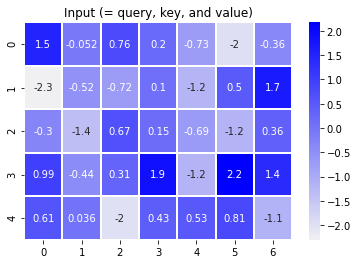

In [22]:
# input
sns.heatmap(Y[0].numpy(), annot=True, cmap=sns.light_palette('blue', as_cmap=True), linewidths=1).set_title('Input (= query, key, and value)');

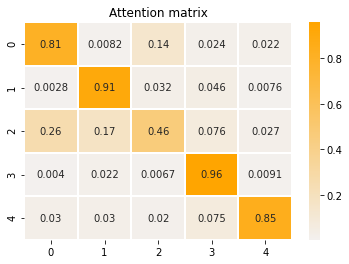

In [23]:
# attention matrix
sns.heatmap(p_attn[0].numpy(), annot=True, cmap=sns.light_palette('orange', as_cmap=True), linewidths=1).set_title('Attention matrix');

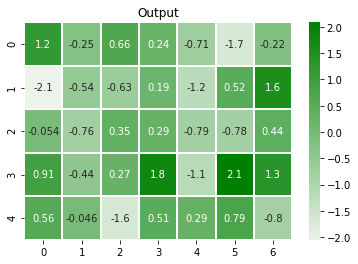

In [24]:
# output
sns.heatmap(out[0].numpy(), annot=True, cmap=sns.light_palette("green", as_cmap=True), linewidths=1).set_title('Output');

Example calculation for the the first element in the output:<br>
The dot product of the first row of the attention matrix (p_attn[0,0]) with the first column of the value matrix (Y[0,:,0]).<br>
0.6 * 0.39 + 0.084 * -0.19 + 0.11 * -0.2 + 0.1 * 1.3 + 0.098 * 0.14 = 0.34 (0.33976)

In [25]:
p_attn[0,0].view(1,-1)

tensor([[0.8055, 0.0082, 0.1402, 0.0244, 0.0218]])

In [26]:
Y[0,:,0].view(-1,1)

tensor([[ 1.5115],
        [-2.2999],
        [-0.2975],
        [ 0.9911],
        [ 0.6079]])

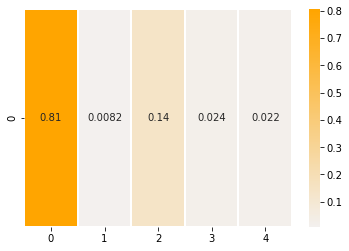

In [27]:
# attention matrix
sns.heatmap(p_attn[0,0].view(1,-1).numpy(), annot=True, cmap=sns.light_palette('orange', as_cmap=True), linewidths=1);

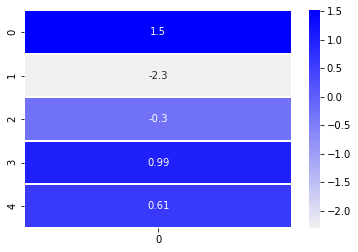

In [28]:
# input
sns.heatmap(Y[0,:,0].view(-1,1).numpy(), annot=True, cmap=sns.light_palette('blue', as_cmap=True), linewidths=1);

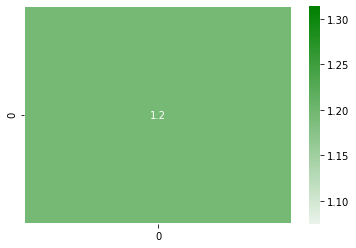

In [29]:
# output
sns.heatmap(out[0,0,0].view(1,1).numpy(), annot=True, cmap=sns.light_palette("green", as_cmap=True), linewidths=1);

# Cosine similarity attention function

$\left (\frac{Q}{\| Q \|} \left (\frac{K}{\| K \|}\right )^{T} \right )\frac{V}{\| V \|}$

In [87]:
# attention function based on http://nlp.seas.harvard.edu/2018/04/03/attention.html#attention
def cossim_attention_transf_einsum(query, key, value):
    "Compute 'Cosine Similarity Attention'"
    
    query = F.normalize(query, dim=-1)
    key   = F.normalize(key,   dim=-1)
    value = F.normalize(value, dim=-1)
    
    # matrix multiplication to get every dot product for query and transposed key
    p_attn = einsum("bij,bmj->bim", query, key)
    
    # matrix multiplication of attention matrix and value matrix to get output based
    out = einsum("bij,bjk->bik", p_attn, value)
    
    return out, p_attn

In [108]:
# run Y through attention function
cossim_out_einsum, cossim_p_attn_einsum = cossim_attention_transf_einsum(Y, Y, Y)

In [118]:
# run Y through attention function
cossim_out_einsum, cossim_p_attn_einsum = cossim_attention_transf_einsum(random_tensors([3, 5, 7]),
                                                                         random_tensors([3, 5, 7]),
                                                                         random_tensors([3, 5, 7]))

In [119]:
# print shapes
Y.shape, p_attn.shape, out.shape

(torch.Size([3, 5, 7]), torch.Size([3, 5, 5]), torch.Size([3, 5, 7]))

In [120]:
# print shapes
Y.shape, cossim_p_attn_einsum.shape, cossim_out_einsum.shape

(torch.Size([3, 5, 7]), torch.Size([3, 5, 5]), torch.Size([3, 5, 7]))

## Visualization

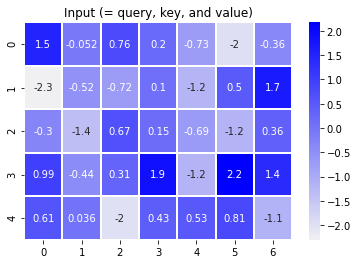

In [121]:
# input
sns.heatmap(Y[0].numpy(), annot=True, cmap=sns.light_palette('blue', as_cmap=True), linewidths=1).set_title('Input (= query, key, and value)');

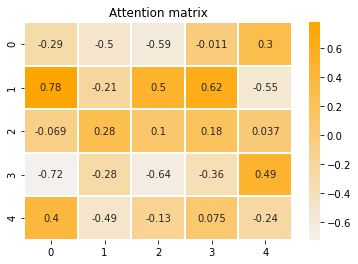

In [122]:
# attention matrix
sns.heatmap(cossim_p_attn_einsum[0].numpy(), annot=True, cmap=sns.light_palette('orange', as_cmap=True), linewidths=1).set_title('Attention matrix');

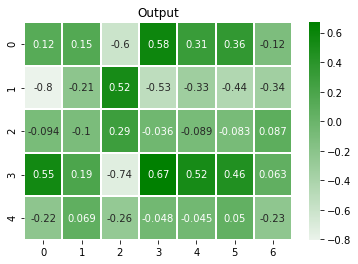

In [123]:
# output
sns.heatmap(cossim_out_einsum[0].numpy(), annot=True, cmap=sns.light_palette("green", as_cmap=True), linewidths=1).set_title('Output');

# End

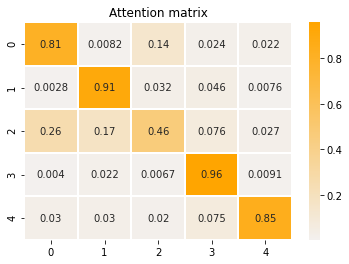

In [124]:
# attention matrix
sns.heatmap(p_attn[0].numpy(), annot=True, cmap=sns.light_palette('orange', as_cmap=True), linewidths=1).set_title('Attention matrix');

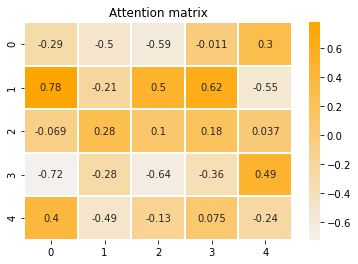

In [125]:
# attention matrix
sns.heatmap(cossim_p_attn_einsum[0].numpy(), annot=True, cmap=sns.light_palette('orange', as_cmap=True), linewidths=1).set_title('Attention matrix');

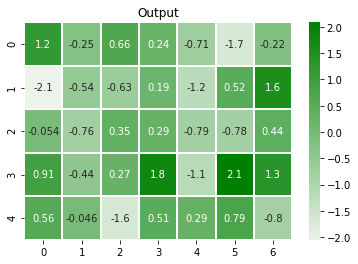

In [126]:
# output
sns.heatmap(out[0].numpy(), annot=True, cmap=sns.light_palette("green", as_cmap=True), linewidths=1).set_title('Output');

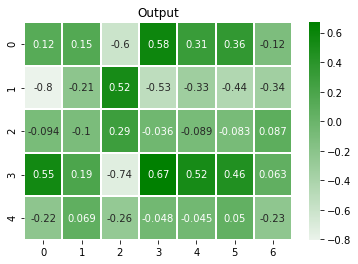

In [127]:
# output
sns.heatmap(cossim_out_einsum[0].numpy(), annot=True, cmap=sns.light_palette("green", as_cmap=True), linewidths=1).set_title('Output');